# Preparation of the data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [2]:
import os
for dirname, _, filenames in os.walk('/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars72.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars55.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars428.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars83.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars407.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars2.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars115.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars245.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars171.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars32.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars78.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars92.png
/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/


## We create the variable X containing all the images of cars by resizing them.


In [3]:

IMAGE_SIZE = 224


In [4]:
img_dir = "/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

### We create the variable y containing all the bounding boxe annotations (label). Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that.

In [5]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [6]:
path = '/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/annotations'
text_files = ['/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [7]:
resizeannotation("/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/annotations/Cars147.xml")

[188, 141, 101, 104]

In [8]:
y[0]

[187, 144, 101, 104]

We check X and y shape

In [9]:
np.array(X).shape

(433, 224, 224, 3)

In [10]:
np.array(y).shape

(433, 4)

# And we display the first twenty image of the dataset :

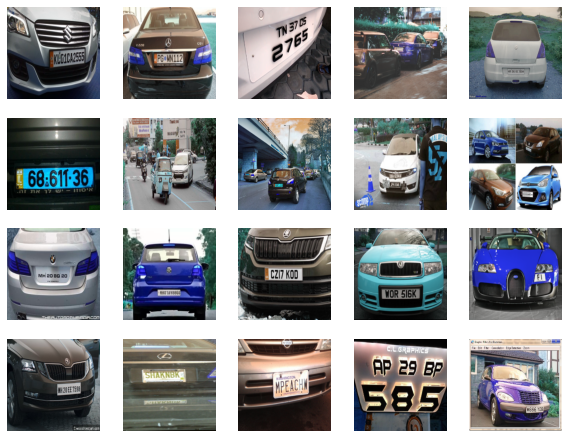

In [11]:
plt.figure(figsize=(10,20))
for i in range(0,20) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

# We can draw the rectangle containing the license plate using the OpenCV library

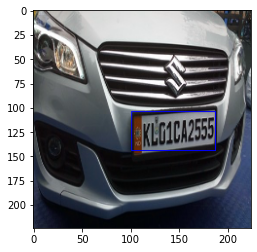

In [12]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

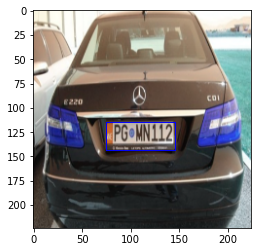

In [13]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

# Preparing for CNN

In [14]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [15]:
#Renormalisation
X = X / 255
y = y / 255

# We split our dataset in two : training set/testing set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

# Convolutionnal Neural Network

In [17]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

## Create the model

In [18]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,951,108
Trainable params: 3,236,420
Non-trainable params: 14,714,688
____________________________________

In [19]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [20]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
10/10 [==============================] - 38s 4s/step - loss: 0.0606 - accuracy: 0.3642 - val_loss: 0.0209 - val_accuracy: 0.6571
Epoch 2/50
10/10 [==============================] - 38s 4s/step - loss: 0.0172 - accuracy: 0.6410 - val_loss: 0.0179 - val_accuracy: 0.6571
Epoch 3/50
10/10 [==============================] - 37s 4s/step - loss: 0.0109 - accuracy: 0.6322 - val_loss: 0.0160 - val_accuracy: 0.5429
Epoch 4/50
10/10 [==============================] - 36s 4s/step - loss: 0.0056 - accuracy: 0.7473 - val_loss: 0.0139 - val_accuracy: 0.8000
Epoch 5/50
10/10 [==============================] - 36s 4s/step - loss: 0.0032 - accuracy: 0.8134 - val_loss: 0.0149 - val_accuracy: 0.6000
Epoch 6/50
10/10 [==============================] - 36s 4s/step - loss: 0.0024 - accuracy: 0.8215 - val_loss: 0.0149 - val_accuracy: 0.6857
Epoch 7/50
10/10 [==============================] - 36s 4s/step - loss: 0.0013 - accuracy: 0.8487 - val_loss: 0.0149 - val_accuracy: 0.8000
Epoch 8/50
10/10 [==

In [21]:
model.save('my_model.h5', overwrite=True) 

In [22]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 83.91%


In [23]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

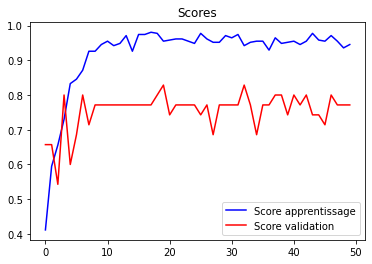

In [24]:
plot_scores(train)

In [25]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

100/100 [==============================] - 9s 93ms/step - loss: 0.0075 - accuracy: 0.8391
Test results 
 Loss: 0.007483365945518017 
 Accuracy 0.8390804529190063


In [56]:
y_cnn = model.predict(X_test)
print(y_cnn)

[[9.96868610e-01 9.90315497e-01 3.07747722e-03 1.98167920e-01]
 [8.93296301e-01 4.91468787e-01 5.34307957e-03 8.63581896e-04]
 [9.96882081e-01 9.15298283e-01 4.24265862e-04 1.89760327e-03]
 [9.94880438e-01 9.93237853e-01 8.20736289e-02 7.08674729e-01]
 [9.99533892e-01 9.94754016e-01 2.38260627e-03 1.80662900e-01]
 [9.94566798e-01 9.87283349e-01 9.60728228e-02 3.28777313e-01]
 [9.99744654e-01 9.96623874e-01 1.98580819e-05 2.19399512e-01]
 [9.96868610e-01 9.90315497e-01 3.07747722e-03 1.98167920e-01]
 [9.93846595e-01 9.86322880e-01 6.62979186e-02 1.60284638e-01]
 [9.87405360e-01 9.83385801e-01 2.26539373e-03 4.35145766e-01]
 [9.97175872e-01 9.88287568e-01 3.95476818e-04 4.82478738e-02]
 [9.99624729e-01 9.92742360e-01 3.30465555e-01 6.77256942e-01]
 [9.91740227e-01 9.83017564e-01 8.20368528e-04 1.17312461e-01]
 [9.64919806e-01 9.44802284e-01 5.40923476e-02 5.79484642e-01]
 [9.89755869e-01 9.83933449e-01 1.95938349e-03 4.50265408e-03]
 [9.52612400e-01 8.80111814e-01 9.40573215e-03 1.849457

# We can see how our model localize license plates on our testing set :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

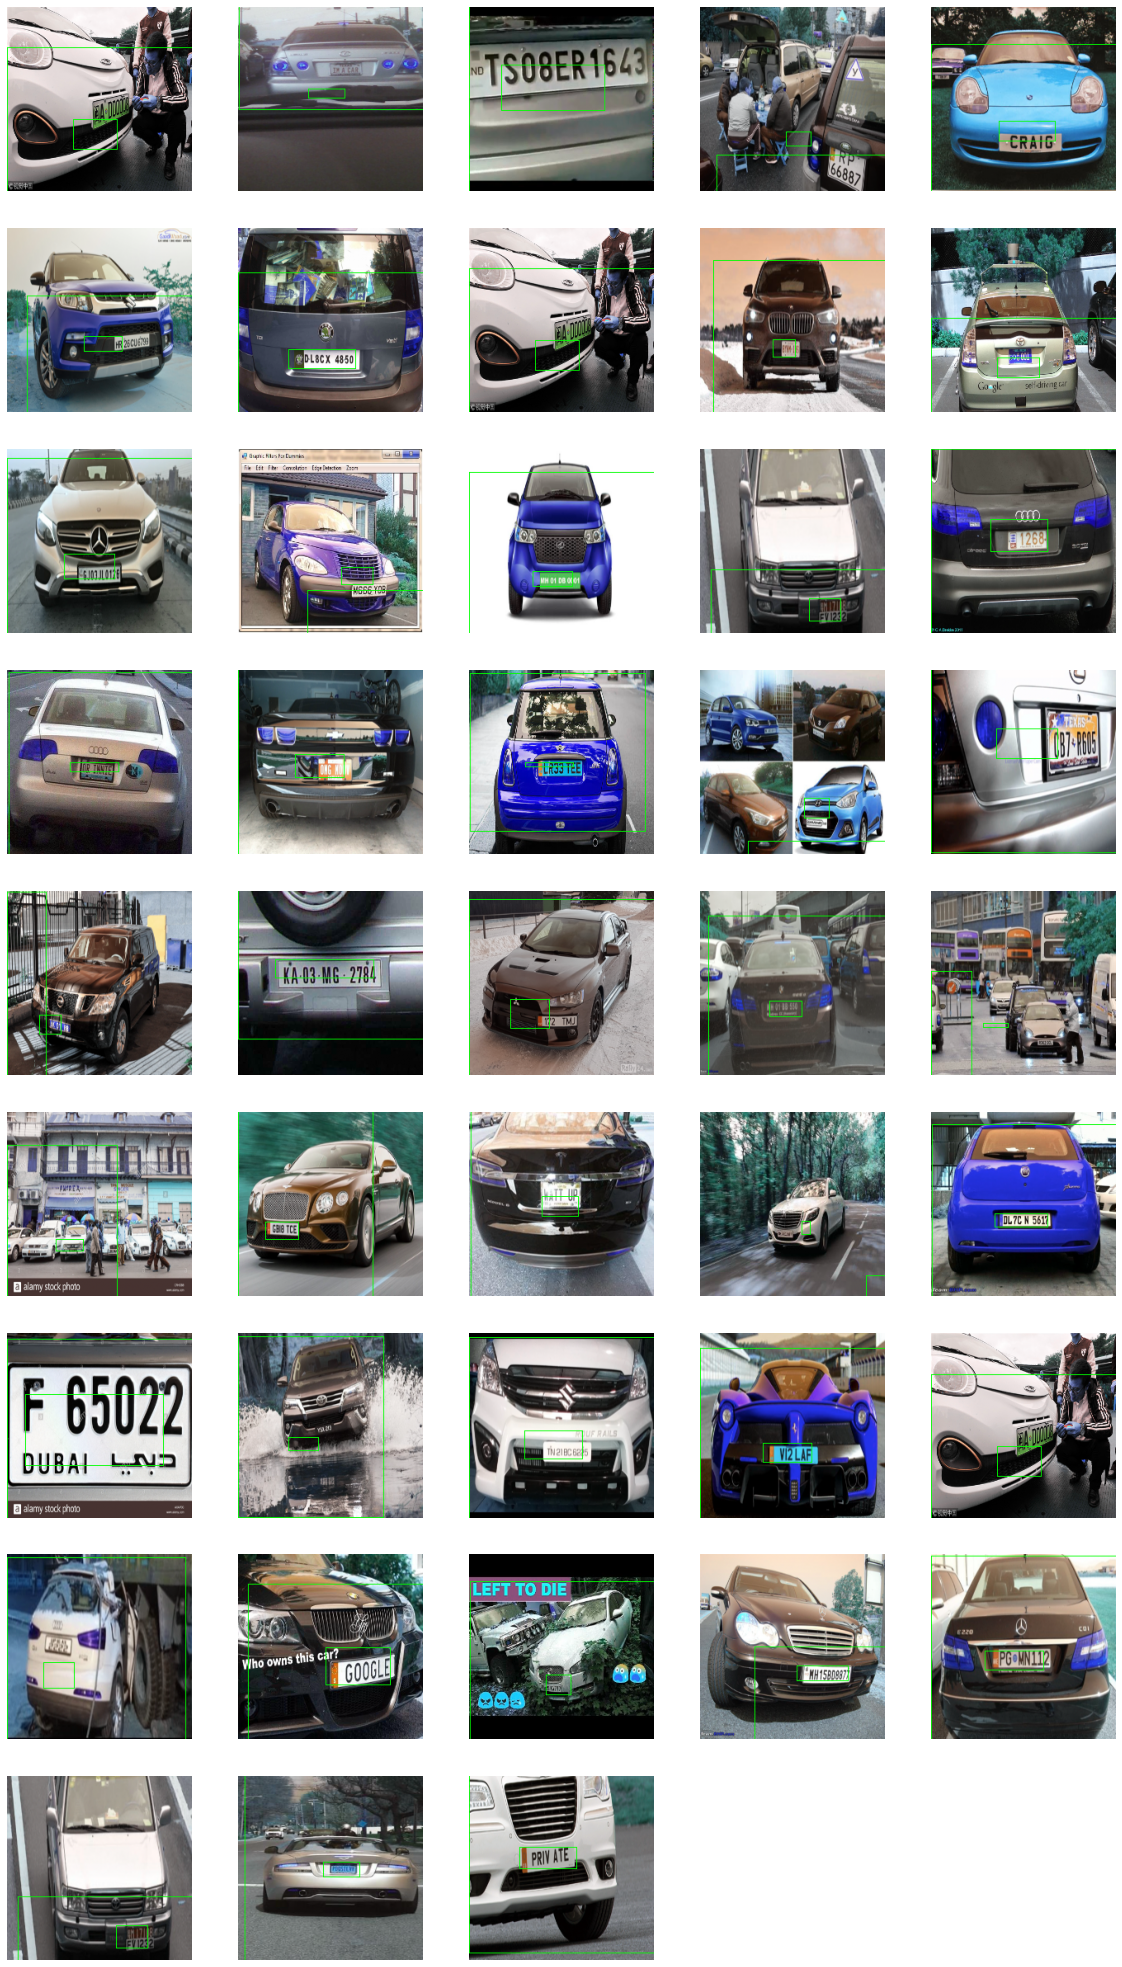

In [59]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

# Character recognition in licence plate


In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
plt.style.use('dark_background')


### Read Input Image

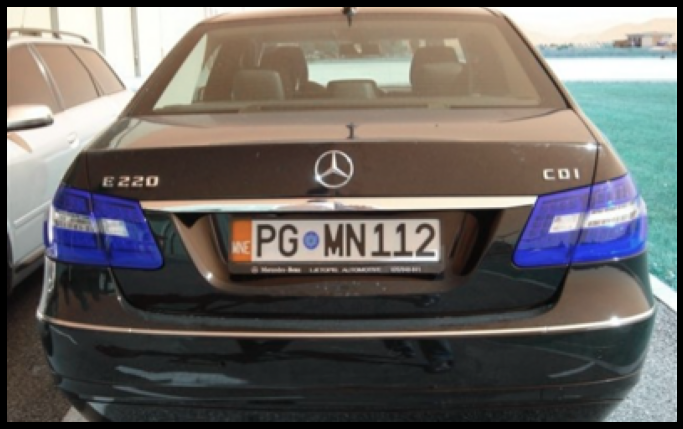

In [88]:


img_ori = cv2.imread('/home/aarsh/Jupyter Notebooks/Licence Plate Detection/Input/images/Cars1.png')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')
plt.axis('off')
plt.savefig('Car.png',bbox_inches = 'tight')
plt.show()




### Convert Image to Grayscale


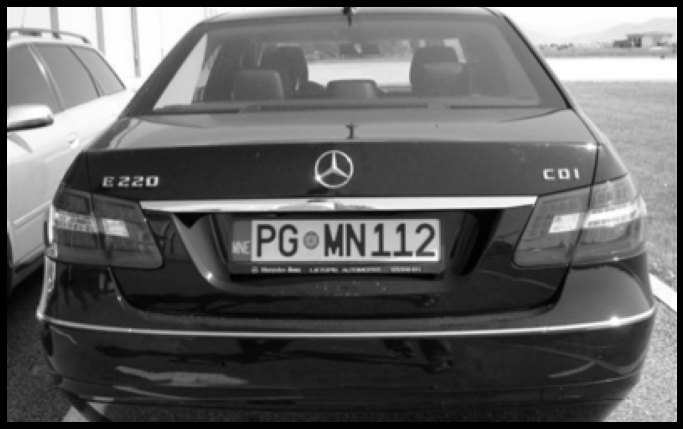

In [89]:

gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Car-GrayScale.png',bbox_inches = 'tight')
plt.show()



### Maximize Contrast

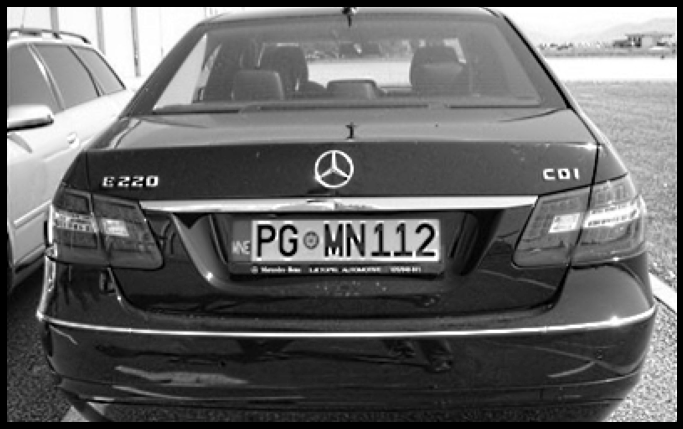

In [90]:

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Car-Contrast.png',bbox_inches = 'tight')
plt.show()



### Adaptive Thresholding

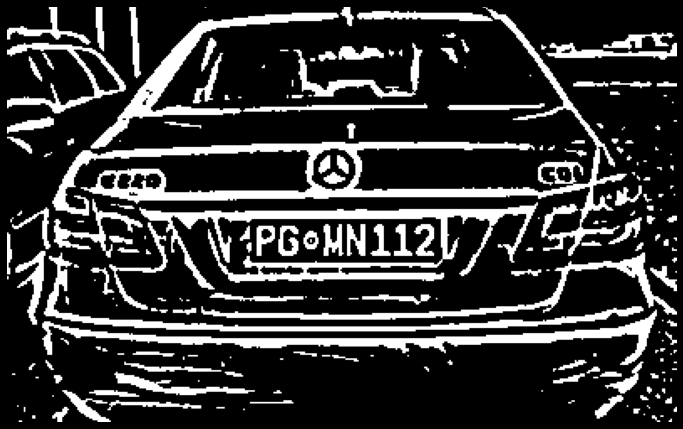

In [91]:


img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')
plt.savefig('Car-Adaptive-Thresholding.png',bbox_inches = 'tight')
plt.show()




### Finding Contours to locate plate


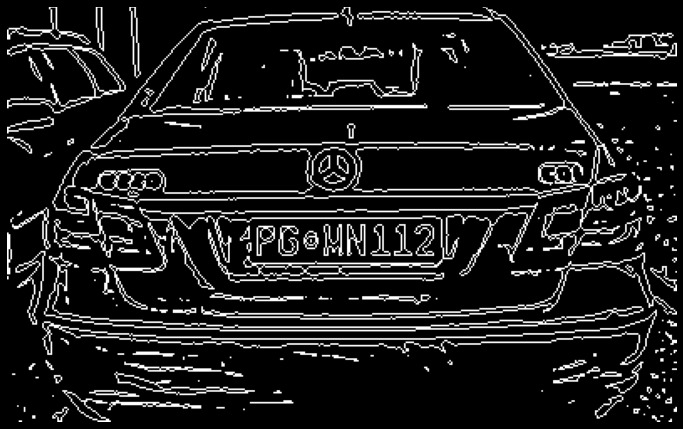

In [92]:

contours, _= cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.axis('off')
plt.savefig('Car-Contours.png',bbox_inches = 'tight')
plt.show()




### Data Preparation


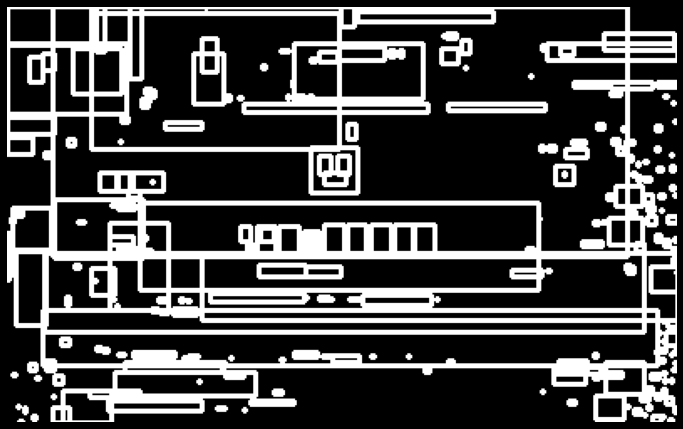

In [93]:

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes.png',bbox_inches = 'tight')
plt.show()



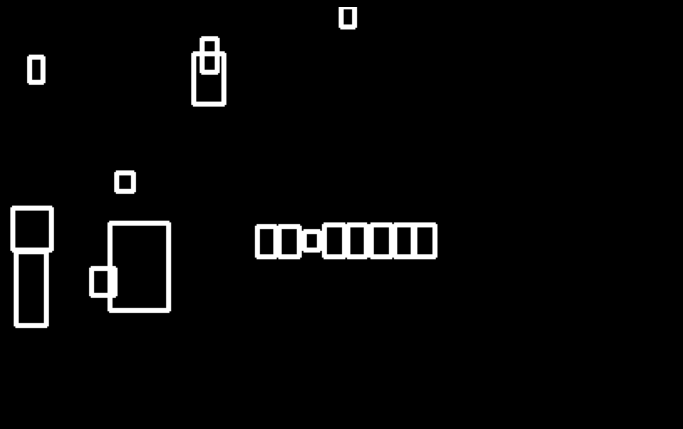

In [94]:

# Selecting Boxes by Char Size

MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes-byCharSize.png',bbox_inches = 'tight')
plt.show()



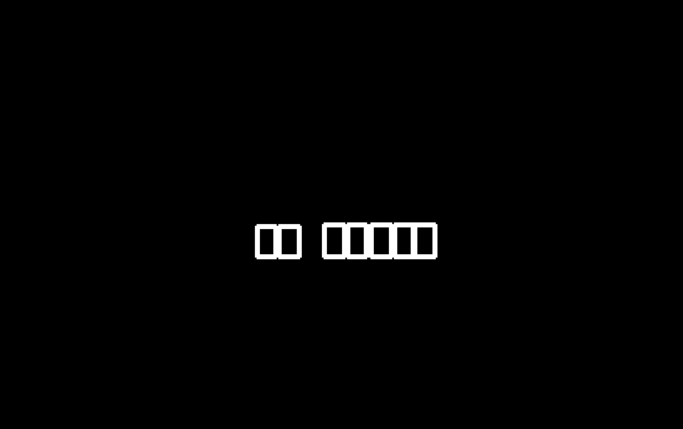

In [95]:

# Selecting Boxes by Arrangement of Contours

MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 12.0 # 12.0
MAX_AREA_DIFF = 0.5 # 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 # 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()




# Imposing Boxes on Original Image of Car

##    Drawing Boxes on the characters of license plate(To see progress)

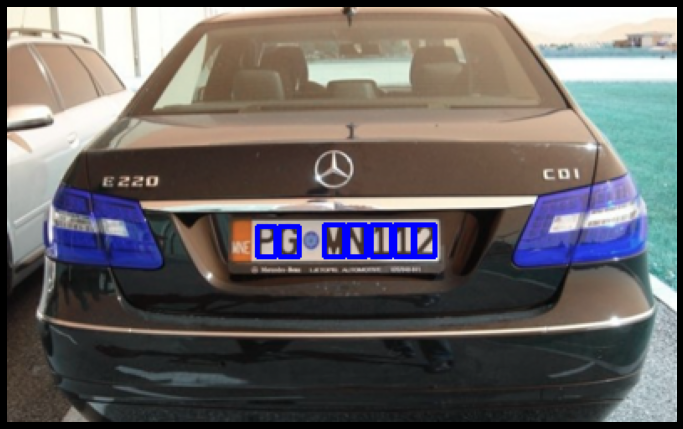

In [96]:


result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(img_ori, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')
plt.axis('off')
plt.savefig('Car-OverlappingBoxes.png',bbox_inches = 'tight')
plt.show()



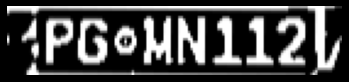

In [97]:

# Rotate Plate Images

PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')
    plt.axis('off')
    plt.savefig('Car-Plates(Rotated).png',bbox_inches = 'tight')
    plt.show()




# Thresholding Again to Find Chars

## Making the Chars more distinctive

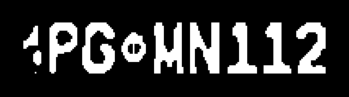

In [98]:


longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    plt.axis('off')
    plt.savefig('Car-Plates(Thresholding).png',bbox_inches = 'tight')
    plt.show()
    break




### Taking Negative Again


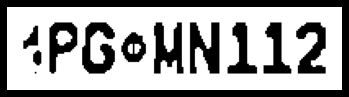

In [99]:

img = 255-img_result
plt.imshow(img, 'gray')
plt.axis('off')
plt.savefig('Car-Plates(Negative).png',bbox_inches = 'tight')
plt.show()
#border is black because remember i set the background to be black



In [100]:

#A function to find Contours again in the cropped license plate

def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.axis('off')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res




# A function to seperate the characters

## Find characters in the resulting images

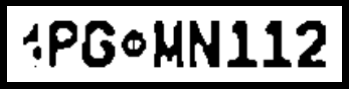

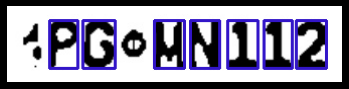

In [101]:

def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))

    LP_WIDTH = img_lp.shape[0]
    LP_HEIGHT = img_lp.shape[1]

    # Make borders white
    img_lp[0:3,:] = 255
    img_lp[:,0:3] = 255
    img_lp[72:75,:] = 255
    img_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_lp, cmap='gray')
    plt.axis('off')
    plt.show()
    cv2.imwrite('contour.jpg', img_lp)
    

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_lp)

    return char_list

char = segment_characters(img)



In [102]:


plt.style.use('ggplot')




# Separating the Characters in the Plate

##    Separating the Characters in the Plate to identify them seperatly and using the model definied later for it

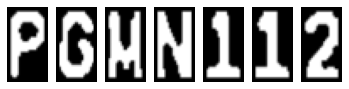

In [103]:


for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.savefig('Car-Plates-Char(Seperated).png',bbox_inches = 'tight')



In [105]:

#Libraries for Model Training

import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from keras.models import Sequential,model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import tensorflow.keras.backend as K




## Training and Validation Data Processing for character recognition


In [152]:

train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/home/aarsh/Jupyter Notebooks/Licence Plate Detection/data'
train_generator = train_datagen.flow_from_directory(
        path+'/data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')



Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [153]:


def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")

def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./{}.h5".format(model_name))
    return model





## Model for Training


In [154]:

K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])



In [155]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       131200    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3


## Making a Condition for Ending the Training Quickly once the required accuracy is achieved


In [156]:

class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
              self.model.stop_training = True




# Training


In [157]:

batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)



Epoch 1/80
864/864 [==============================] - 37s 42ms/step - loss: 3.5372 - custom_f1score: 0.0520 - val_loss: 2.4102 - val_custom_f1score: 0.3036
Epoch 2/80
864/864 [==============================] - 37s 42ms/step - loss: 2.1106 - custom_f1score: 0.4032 - val_loss: 0.9329 - val_custom_f1score: 0.7664
Epoch 3/80
864/864 [==============================] - 36s 42ms/step - loss: 0.9673 - custom_f1score: 0.6877 - val_loss: 0.2854 - val_custom_f1score: 0.9226
Epoch 4/80
864/864 [==============================] - 36s 42ms/step - loss: 0.4954 - custom_f1score: 0.8286 - val_loss: 0.3125 - val_custom_f1score: 0.8899
Epoch 5/80
864/864 [==============================] - 37s 42ms/step - loss: 0.3431 - custom_f1score: 0.9013 - val_loss: 0.2016 - val_custom_f1score: 0.9315
Epoch 6/80
864/864 [==============================] - 37s 42ms/step - loss: 0.2848 - custom_f1score: 0.9108 - val_loss: 0.1297 - val_custom_f1score: 0.9598
Epoch 7/80
864/864 [==============================] - 37s 42ms/s

In [167]:
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

## Storing keras model

In [169]:

store_keras_model(model, 'model_LicensePlate')


Saved model to disk



### Loading the Pre-Trained Model(remove the Comments and run it)


In [171]:

pre_trained_model = load_keras_model('model_LicensePlate')
model = pre_trained_model 




#### Checking if the model is the same


In [172]:

print(pre_trained_model.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       131200    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3


## Predicting the Output and Showcasing the Result


In [173]:

def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img 
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())



/home/aarsh/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


PGMN112


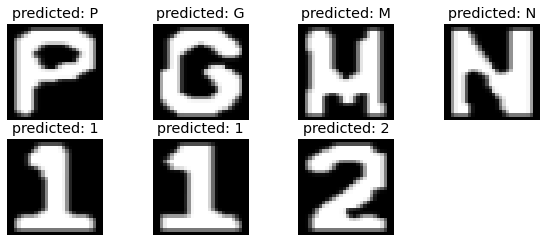

In [174]:

#Segmented characters and their predicted value¶

# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    title_obj = plt.title(f'predicted: {show_results()[i]}')
    plt.setp(title_obj, color='black')
    plt.axis('off')
plt.show()



# THANK YOU